<a href="https://colab.research.google.com/github/glf58/Projet_Covid/blob/GLF/Generate_masks_dice_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import shutil
import datetime 
import tensorflow as tf

from google.colab import drive
from zipfile import ZipFile

from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path_out = '/content' #chemin dans l'env. colab ou on va copier les data de test supplementaires
path_drive = '/content/drive/MyDrive/kaggle'   # chemin de l'archive qui contient le fichier kaggle.json necessaire pour telecharger les donnees

#on telecharge les donnees depuis kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
os.mkdir(os.path.join(path_out, 'kaggle'))
shutil.copy(os.path.join(path_drive, 'kaggle.json'), os.path.join(path_out, 'kaggle', 'kaggle.json'))
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

#on dezippe les donnees
archive = '/content/covid19-radiography-database.zip'
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall(path_out)

 98% 761M/778M [00:12<00:00, 68.4MB/s]
100% 778M/778M [00:12<00:00, 67.4MB/s]


In [ ]:
# on cree les listes de chemins pours les images et les masques
cats = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
path_data = '/content/COVID-19_Radiography_Dataset'

list_path_imgs = []
list_path_masks = []

for i in range(len(cats)):
  aux_imgs = sorted(
    [
        os.path.join(path_data, cats[i], 'images', fname)
        for fname in os.listdir(os.path.join(path_data, cats[i], 'images'))
        if fname.endswith(".png")
    ]
  )
  list_path_imgs += aux_imgs

  aux_masks = sorted(
    [
        os.path.join(path_data, cats[i], 'masks', fname)
        for fname in os.listdir(os.path.join(path_data, cats[i], 'masks'))
        if fname.endswith(".png")
    ]
  )
  list_path_masks += aux_masks

  if len(aux_masks) != len(aux_imgs):
    print("PB DANS LES DONNEES")
  
  print("ajout de la categorie {} total images {} total masks {}".format(cats[i], len(list_path_imgs), len(list_path_masks)))
  

ajout de la categorie COVID total images 3616 total masks 3616
ajout de la categorie Lung_Opacity total images 9628 total masks 9628
ajout de la categorie Normal total images 19820 total masks 19820
ajout de la categorie Viral Pneumonia total images 21165 total masks 21165


In [ ]:
# on melange les donnees
list_path_imgs, list_path_masks = shuffle(list_path_imgs, list_path_masks)
list_path_imgs[:10], list_path_masks[:10]

(['/content/COVID-19_Radiography_Dataset/COVID/images/COVID-2746.png',
  '/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1624.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-4691.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-5143.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-6110.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-4107.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-3052.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-155.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-225.png'],
 ['/content/COVID-19_Radiography_Dataset/COVID/masks/COVID-2746.png',
  '/content/COVID-19_Radiography_Dataset/COVID/masks/COVID-1624.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/masks/Lung_Opacity-4691.png',
  

In [ ]:
def load_and_preprocess(img_path, mask_path):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='nearest')
      
  mask = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')/255
      
  return (tf.cast(img, tf.float32)/255.0, tf.cast(mask,tf.uint8))


In [ ]:
IMG_SIZE = 256 #299
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE=32

val_size = 0.15
test_size = 0.15
n_test = int(test_size * len(list_path_imgs))
n_val = n_test + int(val_size * len(list_path_imgs))
print(n_test, n_val)

#on cree les datasets
test = tf.data.Dataset.from_tensor_slices((list_path_imgs[:n_test], list_path_masks[:n_test]))
val = tf.data.Dataset.from_tensor_slices((list_path_imgs[n_test:n_val], list_path_masks[n_test:n_val]))
train = tf.data.Dataset.from_tensor_slices((list_path_imgs[n_val:], list_path_masks[n_val:]))

train = train.shuffle(15000).map(load_and_preprocess, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val = val.shuffle(5000).map(load_and_preprocess, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test = test.map(load_and_preprocess, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

3174 6348


(32, 256, 256, 1) (32, 256, 256, 1)
[0 1]


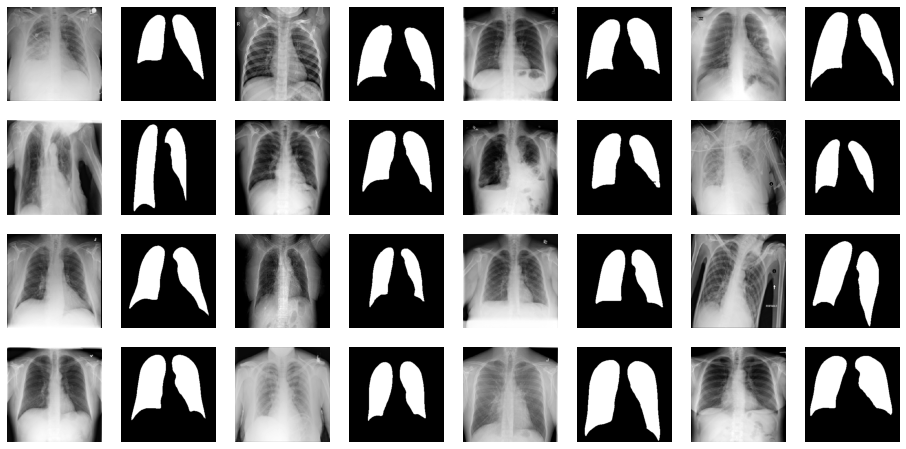

In [ ]:
#on regarde les images/labels du premier batch pour verifier

imgs, masks = next(iter(train))
print(imgs.shape, masks.shape)
print(np.unique(masks[0].numpy()))
plt.figure(figsize=(16,8))
idx = 0
for i in range(4):
  for j in range(4):
    #idx = 8*i+j
    plt.subplot(4,8,idx+1)
    plt.imshow(np.squeeze(imgs[idx], -1), cmap='gray')
    plt.axis('off')
    plt.subplot(4,8,idx+2)
    plt.imshow(np.squeeze(masks[idx], -1), cmap='gray')
    plt.axis('off')
    idx += 2
plt.savefig('images_et_masques.png') 

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x
    
def build_unet(shape, n_filters):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, n_filters, pool=True)
    x2, p2 = conv_block(p1, 2 * n_filters, pool=True)
    x3, p3 = conv_block(p2, 4 * n_filters, pool=True)
    x4, p4 = conv_block(p3, 8 * n_filters, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 8*n_filters, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 8 * n_filters, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 4 * n_filters, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 2 * n_filters, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, n_filters, pool=False)

    """ Output layer """
    output = Conv2D(1, 1, padding="same", activation="sigmoid")(x8)

    return Model(inputs, output)

In [ ]:
a = tf.expand_dims(tf.constant([[[0.2, 0.099], [0.1, 0.9]]]), axis=-1)
b = a>0.5
print(b)
c = tf.where(b, 1, 0)
c.shape, c

tf.Tensor(
[[[[False]
   [False]]

  [[False]
   [ True]]]], shape=(1, 2, 2, 1), dtype=bool)


(TensorShape([1, 2, 2, 1]), <tf.Tensor: shape=(1, 2, 2, 1), dtype=int32, numpy=
 array([[[[0],
          [0]],
 
         [[0],
          [1]]]], dtype=int32)>)

In [ ]:
def dice_coef_tf(y_true, y_pred):

  y_pred_prob = tf.cast(tf.where(y_pred>0.5, 1, 0), dtype=tf.float32)
  y_true = tf.cast(y_true, dtype=tf.float32)
  #print("y true ", y_true)
  #print("y pred prob ", y_pred_prob)
  im_sum = tf.reduce_sum(y_pred_prob, axis=(1,2,3)) + tf.reduce_sum(y_true, axis=(1,2,3))
  #print("im sum ", im_sum)
  inter = tf.reduce_sum(y_true * y_pred_prob, axis=(1,2,3))
  #print("inter ",inter)
  dice = 2. * inter / im_sum
  #print ("dice ",dice.shape, dice)
  dice_batch = tf.reduce_mean(dice, axis=0)
  #print ("dice batch ",dice_batch)
  return dice_batch
  

In [ ]:
essai = tf.expand_dims(tf.constant([[[0, 1, 1], [1, 0, 1], [0, 0, 0]]]), axis=-1)
masque = tf.expand_dims(tf.constant([[[0.8, 0.71, 0.9], [0.61, 0.08, 0.91], [0.2, 0.01, 0.1]]]), axis=-1)
print("dice coef tf", dice_coef_tf(essai, masque))

dice coef tf tf.Tensor(0.8888889, shape=(), dtype=float32)


In [ ]:
def dice_coef_np(im1, im2):

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum(axis=(1,2,3)) + im2.sum(axis=(1,2,3))
    #print(im1, im2, im_sum)
    intersection = np.logical_and(im1, im2)
    #print("intersection ",intersection)
    dice =  (2. * intersection.sum(axis=(1,2,3)) / im_sum)

    return np.mean(dice, axis=0)

In [ ]:
essai_np = np.expand_dims(np.array([[[0, 1], [1, 0]]]), axis=-1)
masque_np = np.expand_dims(np.array([[[1, 1], [1, 0]]]), axis=-1)
dice_coef_np(essai_np, masque_np)

0.8

In [ ]:
Unet = build_unet(shape=(IMG_SIZE, IMG_SIZE, 1), n_filters=8)
Unet.save("'/content/drive/MyDrive/Colab Notebooks/covid/modeles", save_format='tf')
#Unet.summary()
#Unet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_coef_tf], run_eagerly=True)
Unet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_coef_tf])
Unet.summary()

INFO:tensorflow:Assets written to: '/content/drive/MyDrive/Colab Notebooks/covid/modeles/assets
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                      

In [ ]:
es = EarlyStopping(monitor="val_loss",
                   patience=6,
                   restore_best_weights=True, 
                   verbose=1)

red_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5, 
                           patience=2, 
                           verbose=1)

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/covid/modeles',
                             monitor='val_loss', 
                             save_best_only=True, 
                             verbose=1)

training_history_unet = Unet.fit(train,
                                 epochs=3, 
                                 batch_size=BATCH_SIZE, 
                                 validation_data=val,
                                 callbacks=[es, red_lr, checkpoint])

Epoch 1/3
463/464 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9908 - dice_coef_tf: 0.9791
Epoch 1: val_loss improved from inf to 0.02517, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/assets
464/464 [==============================] - 139s 298ms/step - loss: 0.0245 - accuracy: 0.9908 - dice_coef_tf: 0.9791 - val_loss: 0.0252 - val_accuracy: 0.9903 - val_dice_coef_tf: 0.9776 - lr: 0.0010
Epoch 2/3
463/464 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9920 - dice_coef_tf: 0.9819
Epoch 2: val_loss did not improve from 0.02517
464/464 [==============================] - 132s 284ms/step - loss: 0.0203 - accuracy: 0.9920 - dice_coef_tf: 0.9820 - val_loss: 0.0340 - val_accuracy: 0.9870 - val_dice_coef_tf: 0.9699 - lr: 0.0010
Epoch 3/3
463/464 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9924 - dice_coef_tf

In [ ]:
 def show_training_model(hist, save=False, mod='mod'):
    fig = plt.figure(figsize=(10,5))
    epochs = len(hist.history['accuracy'])
    ax1 = fig.add_subplot(121)
    ax1.plot(np.arange(1,epochs+1,1), hist.history['accuracy'], 'blue', label='training')
    ax1.plot(np.arange(1,epochs+1,1), hist.history['val_accuracy'], 'r', label='validation')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    ax1.legend()
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(1,epochs+1,1), hist.history['loss'], 'blue', label='training')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax3 = ax2.twinx()
    ax3.plot(np.arange(1,epochs+1,1), hist.history['val_loss'], 'r', label='validation')
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('Loss')
    ax3.legend(loc='upper left')
    if save:
        plt.savefig(mod+'.png')

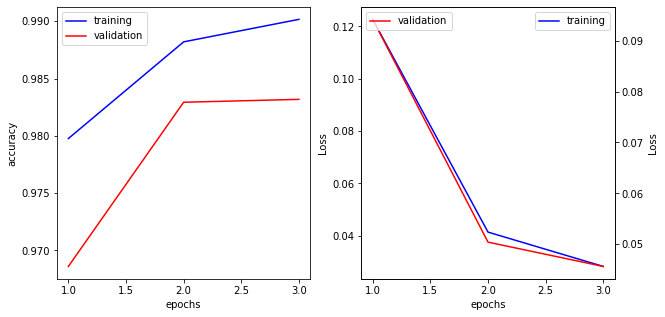

In [ ]:
show_training_model(training_history_unet, save=False, mod='/content/drive/MyDrive/Colab Notebooks/covid/results/Unet_8filters_bilinear')

In [ ]:
#on regarde qq images produites sur l'ensemble de test
affiche = 5
titres = ['inital img', 'intital mask', 'predicted mask']

test = tf.data.Dataset.from_tensor_slices((list_path_imgs[:n_test], list_path_masks[:n_test]))
test = test.map(load_and_preprocess, num_parallel_calls=AUTO).batch(10).prefetch(AUTO)

imgs, masks = next(iter(test))
predicted_prob_masks = Unet.predict(imgs)
#print(type(predicted_prob_masks), predicted_prob_masks[0].min(), predicted_prob_masks[0].max())
predicted_masks = [np.where(predicted_prob_masks[i,:,:,:]<0.5,0,1) for i in range(affiche)]
predicted_masks = np.array(predicted_masks)
dc=[]
for i in range(affiche):
  a = np.expand_dims(masks[i,:,:,:], axis=0)
  b = np.expand_dims(predicted_masks[i,:,:,:], axis=0)
  #print("a, b",a.shape, b.shape)
  c = dice_coef_np(a, b)
  #print(c)
  dc.append(c)

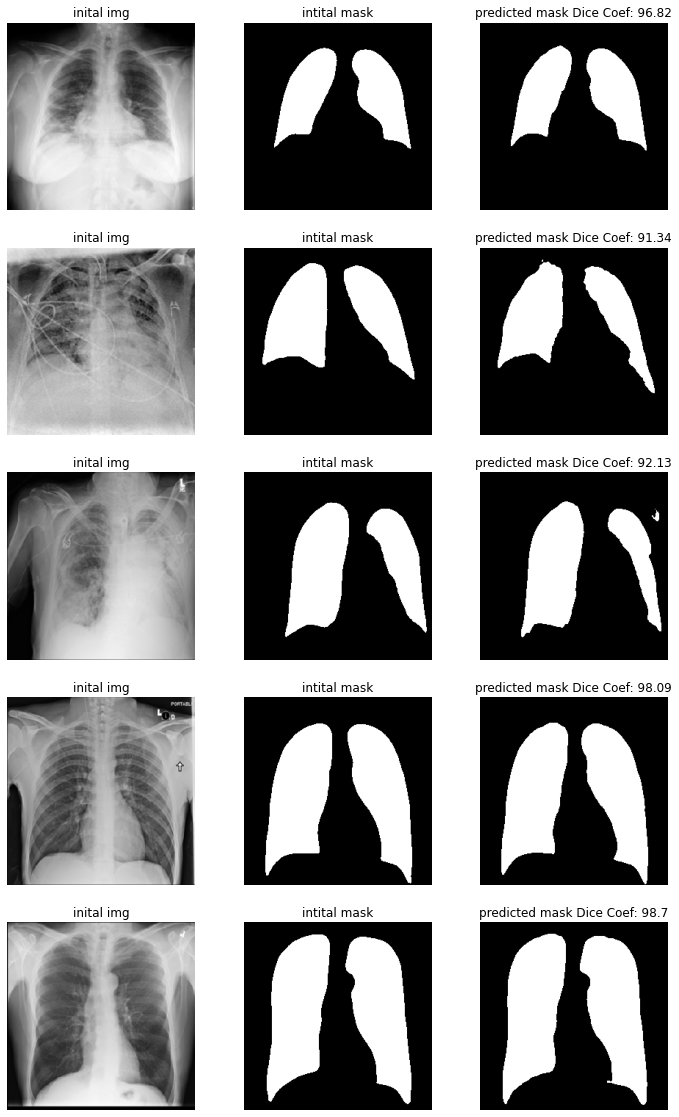

In [ ]:
plt.figure(figsize=(12,20))

for i in range(affiche):
  plt.subplot(affiche,3,3*i+1)
  plt.imshow(np.squeeze(imgs[i].numpy(),-1), cmap='gray')
  plt.title(titres[0])
  plt.axis('off')
  plt.subplot(affiche,3,3*i+2)
  plt.imshow(np.squeeze(masks[i].numpy(),-1), cmap='gray')
  plt.title(titres[1])
  plt.axis('off')
  plt.subplot(affiche,3,3*i+3)
  plt.imshow(np.squeeze(predicted_masks[i],-1), cmap = 'gray')
  plt.title(titres[2]+' Dice Coef: '+str(round(100*dc[i], 2)))
  plt.axis('off')
if False:
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/covid/results/Unet_8filters_bilinear_test_results.png')